In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
sns.set_context('poster', font_scale=1.25)

In [6]:
import findspark as fs

In [7]:
fs.init()

In [8]:
import pyspark as ps

In [9]:
config = ps.SparkConf()
config = config.setAppName('marvel_solver')

In [10]:
sc = ps.SparkContext(conf=config)

# Graph work

In [11]:
marvel_raw_data = sc.textFile('marvel_data.csv')

In [12]:
marvel_raw_data.take(10)

[u'"FROST, CARMILLA","AA2 35"',
 u'"KILLRAVEN/JONATHAN R","AA2 35"',
 u'"M\'SHULLA","AA2 35"',
 u'"24-HOUR MAN/EMMANUEL","AA2 35"',
 u'"OLD SKULL","AA2 35"',
 u'"G\'RATH","AA2 35"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 35"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 36"',
 u'"3-D MAN/CHARLES CHAN","M/PRM 37"',
 u'"HUMAN ROBOT","WI? 9"']

In [13]:
def get_issue_character(raw_line):
    dat = raw_line.split('"')
    character_name = dat[1]
    issue = dat[3]
    return (issue, character_name)

In [14]:
issue_character_rdd = marvel_raw_data.map(get_issue_character)

Links are symmetric. We can just create key/value pairs from this. We want character as a key, values as everyone they link to. If one character links to another, the other character *must* link to them!

In [15]:
issue_groups_rdd = issue_character_rdd.groupByKey()

In [16]:
muffin = [(2,3),(4,5)]

In [17]:
def get_links_from_groups(x):
    list_of_characters = list(x[1])
    links = []
    for cur_character in list_of_characters:
        for other_character in list_of_characters:
            if cur_character != other_character:
                # Ensure that links are symmetric
                links.append((cur_character, other_character))
                links.append((other_character, cur_character))
    return tuple(links)

In [18]:
all_links_rdd = issue_groups_rdd.flatMap(get_links_from_groups)

We now groupby key again. And then we have all the links for a given individual. *But* we have to make sure they are unique.

In [19]:
all_links_rdd.take(2)

[(u'PRINCESS ZANDA', u"BLACK PANTHER/T'CHAL"),
 (u"BLACK PANTHER/T'CHAL", u'PRINCESS ZANDA')]

In [20]:
character_and_links_rdd = all_links_rdd.groupByKey()

In [21]:
def cleanup_links(x):
    linked_to = list(x[1])
    unique_links = tuple(set(linked_to))
    return (x[0], unique_links)

In [22]:
character_and_links_rdd.take(1)

[(u'QUESADA, JOE', <pyspark.resultiterable.ResultIterable at 0x7fc1a33e6f10>)]

In [23]:
network_rdd = character_and_links_rdd.map(cleanup_links)

Ok, awesome. We are all set.

In [24]:
network_result = network_rdd.collect()

In [25]:
import cPickle as pkl

In [26]:
with open('marvel_network.pkl', 'wb') as fi:
    pkl.dump(network_result, fi)

In [27]:
network_result[0:5]

[(u'QUESADA, JOE',
  (u'ZURI',
   u'GLADIATOR/MELVIN POT',
   u'SMITH, KEVIN',
   u'OKOYE',
   u'PALMIOTTI, JIMMY',
   u'MARTINEZ, ALITHA',
   u'MYSTERIO/QUENTIN BEC',
   u'WATSON-PARKER, MARY ',
   u'SPIDER-MAN/PETER PAR',
   u'MCKENZIE, LYDIA',
   u'LAMY, KELLY',
   u'URICH, BEN',
   u"BLACK PANTHER/T'CHAL",
   u'MR. FANTASTIC/REED R',
   u'THING/BENJAMIN J. GR',
   u'QUINN, ASHLEY',
   u'CAPTAIN AMERICA',
   u'MALICE V/NAKIA',
   u'NELSON, CANDACE',
   u'INVISIBLE WOMAN/SUE ',
   u'BUTCH',
   u'EIGHTBALL',
   u'DAREDEVIL/MATT MURDO',
   u'ROSS, EVERETT KENNET',
   u'POTTER, BETSY BEATTY',
   u'BLACK WIDOW/NATASHA ',
   u'EVERETT, BILL',
   u'BLAKE, BECKY',
   u'DAKESIAN, NANCI',
   u'SHARPE, ROSALINDE',
   u'NELSON, FRANKLIN FOG',
   u'MILLER, FRANK',
   u'HUMAN TORCH/JOHNNY S',
   u'OSBORN, LIZ ALLAN',
   u'DR. STRANGE/STEPHEN ',
   u'DARLA',
   u'RALF',
   u'PAGE, KAREN',
   u'LEE, STAN')),
 (u'CRUSADER II/ARTHUR B',
  (u'HELA [ASGARDIAN]',
   u'X-MAN/NATHAN GREY ',
   u'HOGUN [AS

# Applying my class

This makes no sense. Can we run the eval function instead of importing...?

In [41]:
from HW1.network_commands import BFS

## Captain America

In [42]:
network_rdd.is_cached

False

In [43]:
import HW1

In [44]:
HW1.network_commands.num_partitions

40

In [45]:
searcher = BFS(sc, 'CAPTAIN AMERICA', network_rdd)

In [46]:
searcher.run_until_converged()

Finished at end of iteration 4 !


In [49]:
captain_america_result = searcher.distance_rdd.collect()

In [50]:
derp = dict(captain_america_result)

In [51]:
muffin = dict(captain_america_result)

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.90600000e+03,   0.00000000e+00,   0.00000000e+00,
          4.46300000e+03,   0.00000000e+00,   0.00000000e+00,
          3.80000000e+01]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

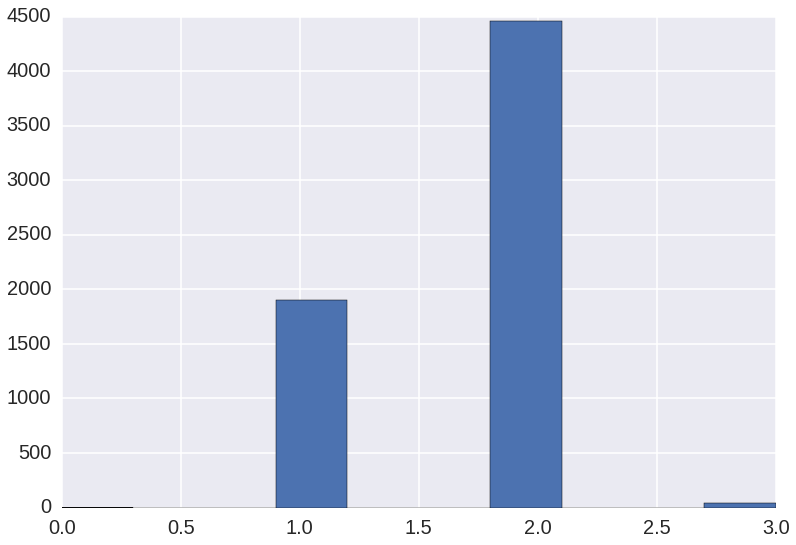

In [52]:
plt.hist(muffin.values())

Cool. The number of nodes touched are

In [53]:
len(muffin)

6408

## Miss Thing/Mary

In [54]:
searcher = BFS(sc, 'MISS THING/MARY', network_rdd)

In [55]:
searcher.run_until_converged()

Finished at end of iteration 2 !


In [78]:
thing_list = searcher.distance_rdd.collect()

In [79]:
muffin = dict(thing_list)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

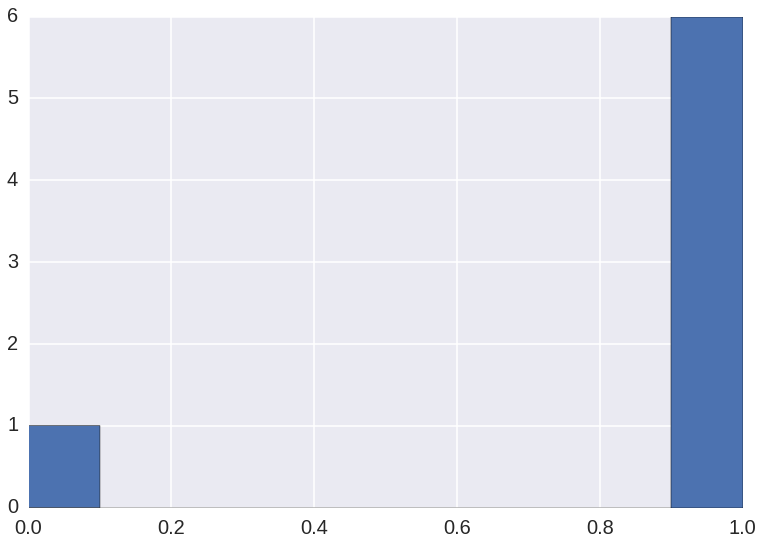

In [80]:
plt.hist(muffin.values())

In [81]:
len(muffin)

7

## Orwell

In [84]:
searcher = BFS(sc, 'ORWELL', network_rdd)

In [85]:
searcher.run_until_converged()

Finished at end of iteration 2 !


In [88]:
orwell_list = searcher.distance_rdd.collect()

In [89]:
muffin = dict(orwell_list)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

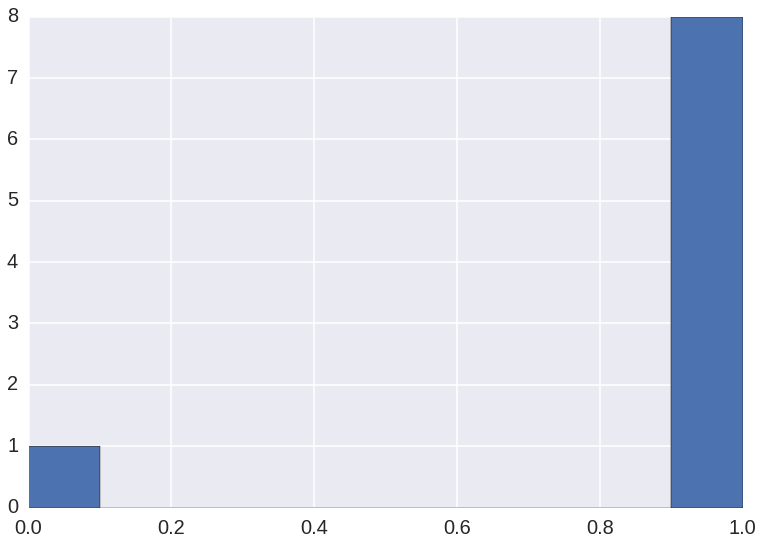

In [90]:
plt.hist(muffin.values())

In [91]:
len(orwell_list)

9

In [93]:
orwell_list

[(u'ASHER, CARL', 1),
 (u'OSWALD', 1),
 (u'NILES, SEN. CATHERIN', 1),
 (u'LUDLUM, ROSS', 1),
 (u'ASHER, MICHAEL', 1),
 (u'FAGIN', 1),
 (u'ASHER, DONNA', 1),
 ('ORWELL', 0),
 (u'HOFFMAN', 1)]

Well, I think this is the first part of the problem. I don't really understand how to optimize with accumulators though. Also, let us write code to make the network converge.

In [113]:
network_rdd = network_rdd.cache()

In [116]:
network_rdd.is_cached

True

# Running until converged

In [117]:
searcher = BFS(sc, 'CAPTAIN AMERICA', network_rdd)

In [118]:
searcher.run_until_converged()

Finished at end of iteration 4 !


In [103]:
searcher = BFS(sc, 'ORWELL', network_rdd)

In [104]:
searcher.run_until_converged()

Finished at end of iteration 2 !


In [92]:
a={'a':1, 'b':2, 'c':3}
b = {'c':2, 'b':2, 'a':1, 'd':69}

In [ ]:
assert cmp